In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

# Setting up

In [2]:
comp = 'paddy-disease-classification'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
path

Path('../input/paddy-disease-classification')

## Import data

In [4]:
from fastai.vision.all import *
set_seed(42)

path.ls()

(#4) [Path('../input/paddy-disease-classification/sample_submission.csv'),Path('../input/paddy-disease-classification/train_images'),Path('../input/paddy-disease-classification/train.csv'),Path('../input/paddy-disease-classification/test_images')]

## Looking at data

In [5]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

Image size:  (480, 640)


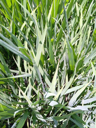

In [7]:
img = PILImage.create(files[0])
print("Image size: ", img.size)
img.to_thumb(128)

Looks like the images might be 480x640 -- let's check all their sizes. This is faster if we do it in parallel, so we'll use fastcore's parallel for this:

In [8]:
from fastcore.parallel import *

def f(o): 
    return PILImage.create(o).size

sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
Name: count, dtype: int64

They're nearly all the same size, except for a few. Because of those few, however, we'll need to make sure we always resize each image to common dimensions first, otherwise fastai won't be able to create batches. For now, we'll just **squish them to 480x480 images**, and then once they're in batches we do a random resized crop down to a smaller size, along with the other default fastai augmentations provided by aug_transforms. We'll start out with small resized images, since we want to be able to iterate quickly:

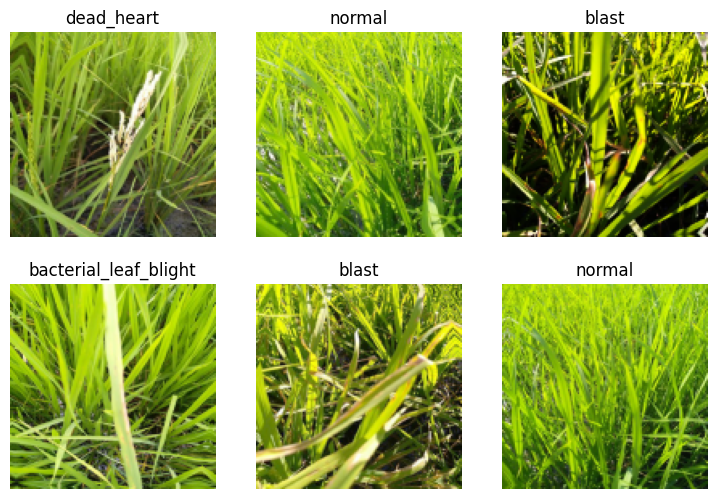

In [10]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
                                  item_tfms=Resize(480, method='squish'), 
                                  batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

Guarantee everything in the mini batch has the same size

## Our first model

Pick `resnet26d` because it is the fastest resolution-independent model which gets into the top-15 lists there

In [11]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

See what the learning rate finder shows:

SuggestedLRs(valley=0.0008317637839354575, slide=0.0030199517495930195)

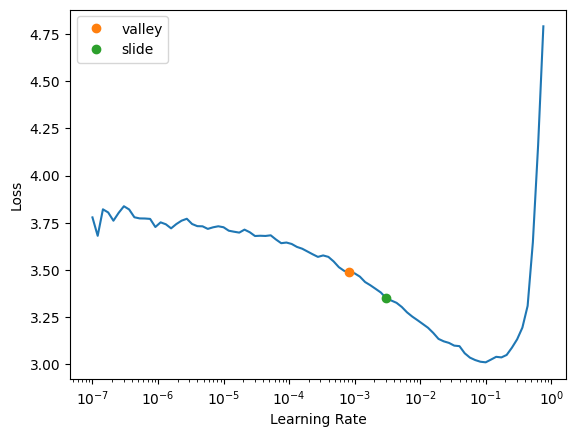

In [12]:
learn.lr_find(suggest_funcs=(valley, slide))

`lr_find` generally recommends rather conservative learning rates, to ensure that your model will train successfully. I generally like to push it a bit higher if I can. Let's train a few epochs and see how it looks:

In [13]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.799231,1.160565,0.381547,00:52


epoch,train_loss,valid_loss,error_rate,time
0,1.148849,0.685471,0.218164,00:54
1,0.781392,0.447239,0.149447,00:53
2,0.545749,0.381840,0.120135,00:54


## Submit to Kaggle

In [14]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


We also need a CSV containing test images, in alphabetical order, and the predicted label for each one. We can create the needed test set using fastai like so:

In [15]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

We can now get the probabilities of each class, and the index of the most likely class, from this test set (the 2nd thing returned by `get_preds` are the targets, which are blank for a test set, so we discard them):

In [16]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

tensor([7, 8, 6,  ..., 8, 1, 5])

These need to be mapped to the names of each of these diseases, these names are stored by fastai automatically in the vocab:

In [17]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

We can create an apply this mapping using pandas:

In [18]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                downy_mildew
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [19]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,normal


In [20]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)